In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

%matplotlib inline

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

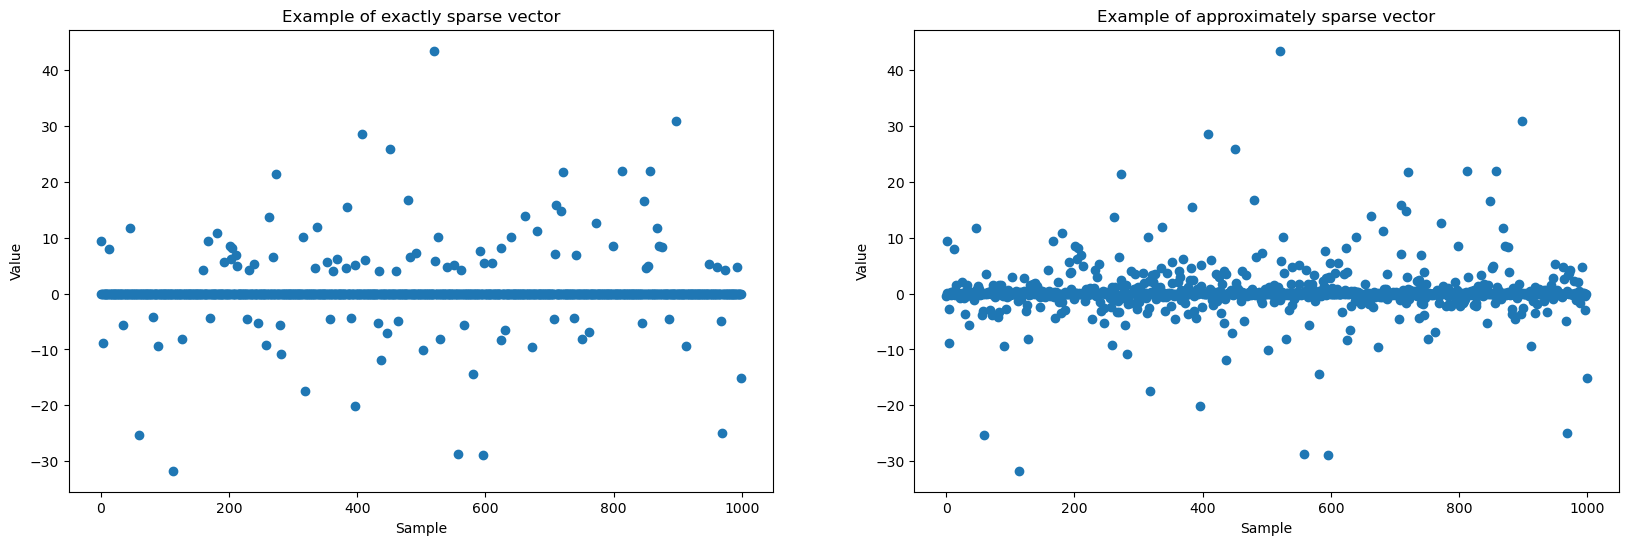

In [2]:
power = 3
approx_sparse = np.random.randn(1000) ** power
exact_sparse = approx_sparse * (np.abs(approx_sparse) > 4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1, 2, 1)
plt.plot(exact_sparse, "o")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Example of exactly sparse vector")

fig.add_subplot(1, 2, 2)
plt.plot(approx_sparse, "o")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Example of approximately sparse vector")
plt.show()

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer**:

Given a signal $\mathbf{s} \in \mathbb{R}^n$, where $\|\cdot\|_0$ denotes the cardinality (number of non-zero elements) of the support of $\mathbf{s}$:
- $\mathbf{s}$ is considered *exactly sparse* if only $k \ll t$ of its elements are non-zero, expressed as $\|\mathbf{s}\|_0 = k \ll t$.
- $\mathbf{s}$ is deemed *approximately sparse* if the cardinality of its support is close to $t$, expressed as $\|\mathbf{s}\|_0 \approx t$.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

**Answer**:

The cross-like (star) shape observed in the scatter plot of the first two sources of the source matrix `S` arises from the characteristics of the sources themselves, which are generated from a uniform distribution raised to a power. This distribution leads to a higher likelihood of samples having lower values in both sources. Consequently, there's a diminished probability of samples exhibiting high values in both sources simultaneously. This tendency creates an axis-like structure in the plot, where samples are more likely to cluster around lower values for one source or the other (forming the arms of the cross), with a decreased likelihood of occurring far from these axes. Thus, the resulting cross shape emerges from the interplay between the distribution's tendency towards lower values and the power transformation applied to the data.

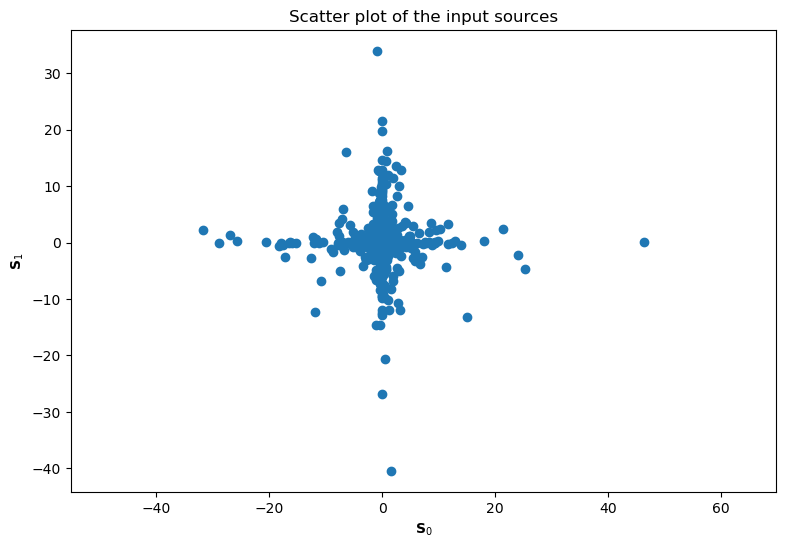

In [3]:
n = 2  # number of sources
t = 1024  # number of samples
noise_level = 119  # noise level, in dB
power = 3  # power exponent used in the source generation

# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
S = np.random.randn(n, t) ** power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1, 2, 1)
plt.title("Scatter plot of the input sources")
plt.plot(S[0, :], S[1, :], "C0o")
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis("equal")
plt.show()

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4  # number of observations

A = np.random.randn(m, n)
X = A @ S

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    # --- Add noise
    N = np.random.randn(m, t)
    N = 10.0 ** (-noise_level / 20.0) * np.linalg.norm(X) / np.linalg.norm(N) * N
    X = X + N

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment ?

**Answer**: 

In the scatter plot of `X`, representing the endmembers (signatures) `A` multiplied by their abundances `S`, a rotated and skewed cross-like shape emerges. The axes of this cross, which were primarily vertical and horizontal in `S`, now form an angle, which can vary in its obtuseness or acuteness depending on different realizations of `A`.

These new directions correspond to the columns of `A`, each encapsulating the weight attributed to a particular source. Thus, they represent the principal axes of the transformed data, indicating the directions in which it exhibits maximum variance.

Altering `A` corresponds to adjusting the mixing proportions of the different sources, leading to distinct distributions in the scatter plot of `S` and varying orientations in the scatter plot of `X`. Consequently, adjusting the noise level impacts the quality of observations: higher noise levels obscure the true signal, making the source separation task more challenging. As a result, increased noise in the scatter plot leads to a greater dispersion of points away from the ideal lines representing the endmembers. Moreover, modifying the power parameter influences the distribution of the original sources. A higher power value makes the source signals more heavy-tailed, which can significantly impact the shape and characteristics of the scatter plot, especially considering the specific distributions of the endmember spectra in the hyperspectral image. Additionally, when using even values for the power parameter, the star-shaped scatter plot may degenerate into an L-shaped scatter plot. This transformation underscores the sensitivity of the data representation to variations in the power parameter, highlighting its importance in shaping the observed patterns in the scatter plot.

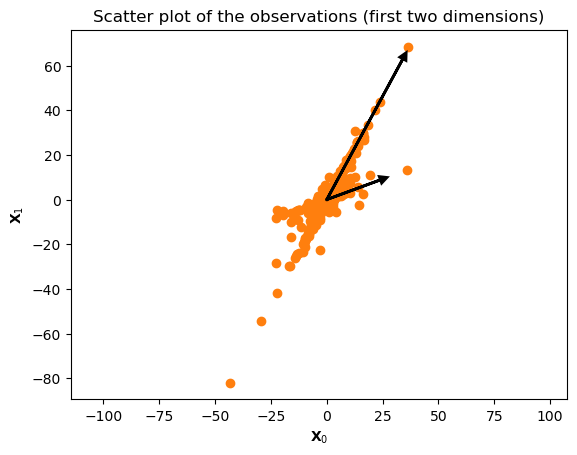

In [5]:
plt.title("Scatter plot of the observations (first two dimensions)")
vrange = 0.25 * max(np.sqrt(np.sum(X * X, 0)))
plt.arrow(
    0,
    0,
    vrange * A[0, 0],
    vrange * A[1, 0],
    fc="k",
    ec="k",
    linewidth=2,
    head_width=0.1 * vrange,
    head_length=0.1 * vrange,
)
plt.arrow(
    0,
    0,
    vrange * A[0, 1],
    vrange * A[1, 1],
    fc="k",
    ec="k",
    linewidth=2,
    head_width=0.1 * vrange,
    head_length=0.1 * vrange,
)
plt.plot(X[0, :], X[1, :], "C1o", zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis("equal")
plt.show()

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

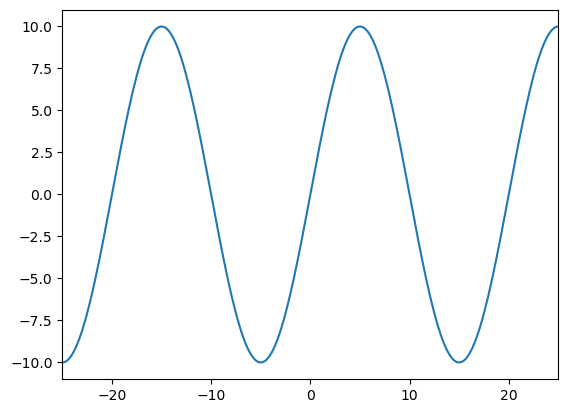

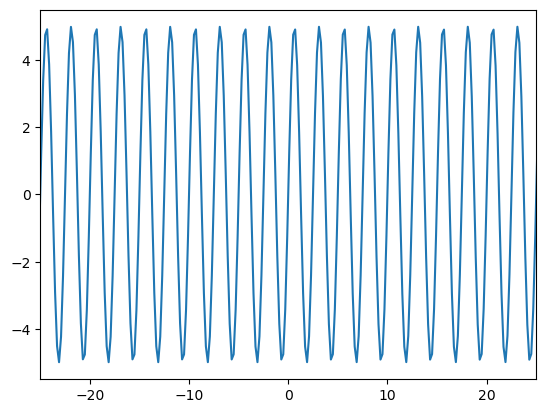

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000, 1000, t)

S = np.zeros((2, t))
S[0, :] = 10 * np.sin(2 * np.pi * 0.05 * x_abs)
S[1, :] = 5 * np.sin(2 * np.pi * 0.4 * x_abs)

plt.figure()
plt.plot(x_abs, S[0, :])
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S[1, :])
plt.xlim([-25, 25])
plt.show()

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer**:

The Discrete Cosine Transform (DCT) is employed across various domains with the primary objective of transforming data from the spatial or time domain to the frequency domain, allowing for efficient data compression, feature extraction, and signal or image processing. By concentrating signal energy into a smaller number of coefficients, the DCT facilitates compression techniques, while also enabling tasks such as denoising, filtering, and feature extraction. Overall, the DCT serves as a versatile tool for efficiently representing and analyzing data across a wide range of applications.

When utilizing the DCT, signals undergo decomposition into their constituent frequencies. Given that the original signals consist of pure sinusoids, each containing only a single non-zero frequency, plotting the absolute values of the DCT reveals peaks corresponding to these frequencies. However, in practice, additional non-zero frequencies may arise due to the finite nature of the sine waves used. Thus, while the primary peaks correspond to the dominant frequencies present in the signals, secondary peaks may also emerge as artifacts of the transformation process.

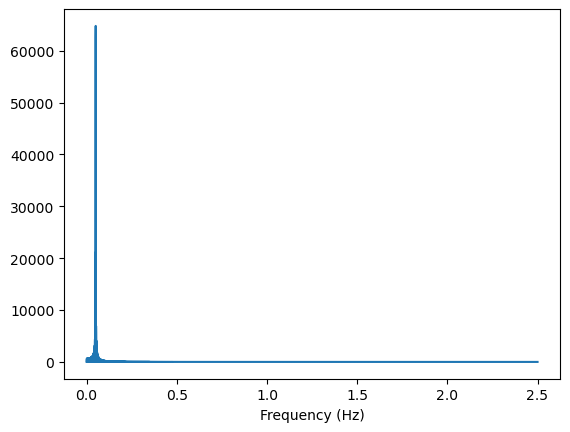

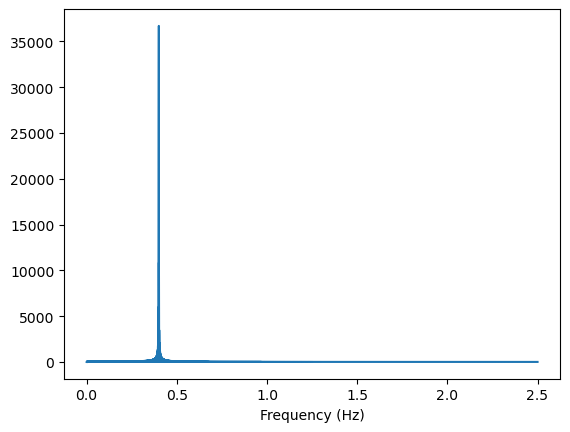

In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)

dt = (np.max(x_abs) - np.min(x_abs)) / len(x_abs)  # Sampling period
T = dt * len(x_abs)  # Duration
nyquist = (len(x_abs) / 2) / T

# Plotting the absolute value of the DCT
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Sf[0, :]))
plt.xlabel("Frequency (Hz)")
plt.plot()
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Sf[1, :]))
plt.xlabel("Frequency (Hz)")
plt.show()

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer**:

The DCT of X exhibits peaks at the same frequencies present in the original signals ($0.05$ and $0.4$), reflecting the frequency components inherent to the sources S. However, due to mixing and added noise, these peaks are less prominent compared to the DCT of the original signals. Additionally, minor peaks at other frequencies are visible, attributed to the presence of noise. Leveraging the fact that the DCT retains peaks at the frequencies of the original sources, source recovery becomes feasible. Since the DCT effectively segregates signals based on their frequency content, identifying frequencies with significant contributions enables informed source separation. Thus, by discerning and isolating relevant frequency components, the DCT facilitates the recovery of the original sources from the mixed signals.

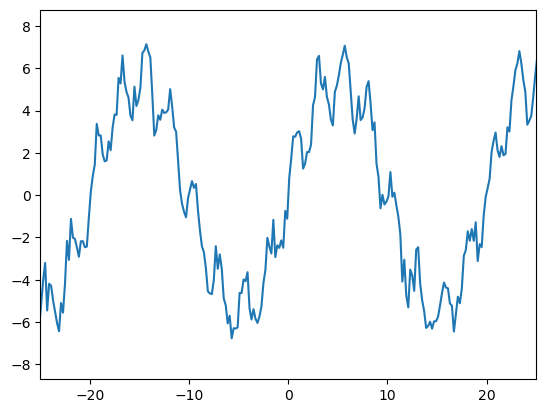

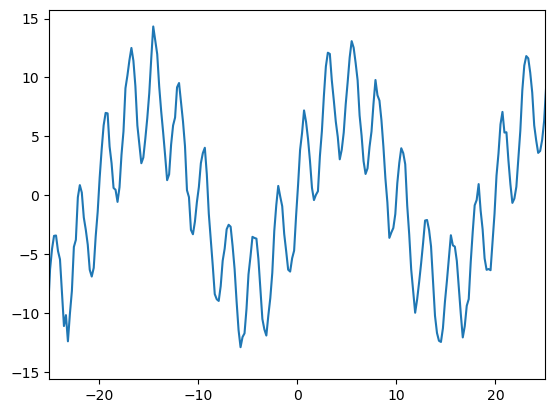

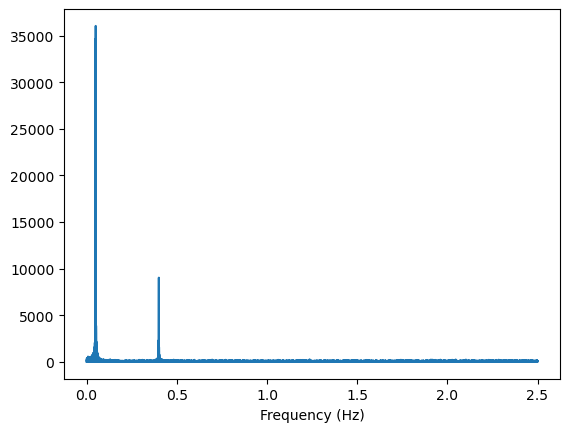

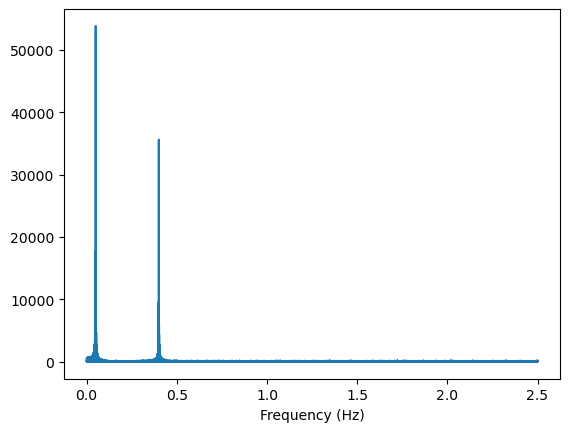

In [8]:
# You can try other A values, but the columns must have a unitary norm.
A = np.array([[0.5547002, 0.24253563], [0.83205029, 0.9701425]])

X = A @ S

# You can try other noise values
X = X + 0.5 * np.random.randn(np.shape(X)[0], np.shape(X)[1])

Xf = sff.dct(X)

# Plotting mixtures
plt.figure()
plt.plot(x_abs, X[0, :])
plt.xlim([-25, 25])

plt.figure()
plt.plot(x_abs, X[1, :])
plt.xlim([-25, 25])


# Plotting the absolute value of the DCT
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Xf[0, :]))
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Xf[1, :]))
plt.xlabel("Frequency (Hz)")
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Answer**:

The cost function is defined as follows:

$$\min_{A \in \mathbb{R}^{m \times n}, S \in \mathbb{R}^{m \times n}} \frac{1}{2} ||X - AS||_F^2 + \lambda ||S||_1$$

- **Data Fidelity Term**: $\frac{1}{2} ||X - AS||_F^2$ measures the dissimilarity between the observed data $X$ and the estimated data $AS$, where $A$ is the known mixing matrix and $S$ is the source matrix to be estimated. The objective is to minimize the difference between $X$ and $AS$, aiming for a solution where $AS$ closely approximates $X$. This term is smooth and convex due to the squared L2 norm, enabling efficient optimization with a unique minimum.

- **Sparsity Term**: $\lambda ||S||_1$ encourages sparsity in the solution. It represents the L1 norm of $S$, which is the sum of the absolute values of its elements, weighted by a regularization parameter $\lambda$. By penalizing solutions with many non-zero elements, the L1 norm promotes sparsity. Although this term is non-smooth due to the absolute value operation, it remains convex, facilitating optimization processes.

Compute the gradient along the S variable of the data-fidelity term.

**Answer**:

The gradient of the data-fidelity term can be expressed as:

$$\nabla_S \left( \frac{1}{2} ||X - AS||_F^2 \right) = -A^T(X - AS)$$

Recall what the proximal operator of the l1-norm is.

**Answer**:

The proximal operator of the $l_1$ norm is indeed the soft-thresholding operator, defined as:

$$
(\text{prox}_{\lambda \| \cdot \|_1}(v))_i = S_{\lambda}(v) =
\begin{cases} 
    v_i - \lambda & \text{if } v_i > \lambda \\
    0 & \text{if } |v_i| \le \lambda \\
    v_i + \lambda & \text{if } v_i < -\lambda
\end{cases}
$$

In [9]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est, thrd):
    S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)
    return S_est

Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer**:

The Iterative Shrinkage-Thresholding Algorithm (ISTA) is a powerful method tailored for solving optimization problems characterized by a combination of a convex, differentiable function and a non-smooth, convex penalty term.

At its core, ISTA adopts an iterative approach to estimate the sparse representation of a signal. It achieves this by repeatedly applying a sequence of thresholding and shrinkage operations. This methodology proves particularly effective in scenarios demanding sparse signal recovery, notably in domains like compressed sensing or sparse regression.

In [10]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X, A=np.eye(2), n=2, lamb=0, nbIt=100):
    S_est = np.zeros((A.shape[1], X.shape[1]))
    gamma = 0.9 / np.linalg.norm(A.T @ A)
    for index in range(nbIt):
        S_est = prox_l1(S_est - gamma * (A.T @ (A @ S_est - X)), lamb)
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer**:

Ensuring that the regularization parameter $\lambda$ remains greater than 0 is crucial, as allowing it to be less than or equal to $0$ would invert the role of the $l_1$ regularization term in the cost function. Rather than promoting sparsity, it would instead encourage a denser solution, which may not align with the desired objective of sparse signal recovery.

On the other hand, if $\lambda$ becomes excessively large, the algorithm may excessively prioritize sparsity, potentially compromising data fidelity. This scenario can lead to underfitting, where the model fails to adequately capture the underlying signal present in the data. In extreme cases where $\lambda$ approaches infinity, the solution is likely to become overly sparse, possibly consisting entirely of zeros, and may struggle to fit the data effectively.

In [11]:
S_estf = ISTA(Xf, A=A, n=2, lamb=1000, nbIt=1000)

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer**:

Plotting the estimated sources in the DCT domain and examining the amplitude values near the peaks reveals that the sources exhibit approximate sparsity. This observation suggests that the majority of the signal's energy is concentrated in certain coefficients, corresponding to the frequencies of the sinusoids present in the original signals. Conversely, the remaining coefficients display values close to zero, indicating minimal contribution to the overall signal. This distribution highlights the sparse nature of the sources, where only a subset of coefficients contains significant information, while the remainder remain effectively negligible.

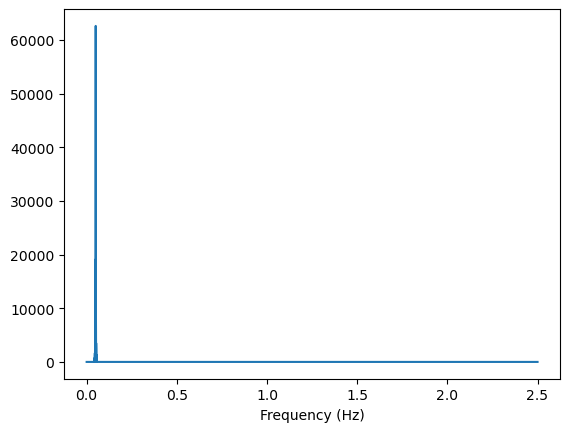

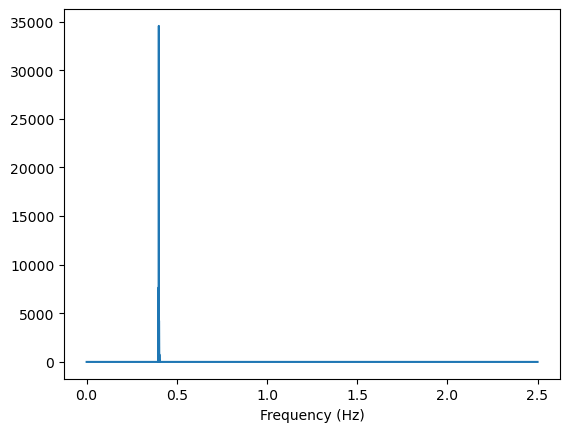

In [12]:
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(S_estf[0, :]) )
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(S_estf[1, :]) )
plt.xlabel("Frequency (Hz)")
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer**:

Observing the estimated sources, it's apparent that they bear resemblance to the original sources in terms of their general shape and structure, which is sinusoidal. However, a noticeable discrepancy lies in the phase shift between the original and estimated sources. 

As the algorithm deals with mixed signals derived from two distinct original sources, achieving perfect reconstruction of the original signals is inherently challenging. One common discrepancy encountered is a phase shift between the estimated and true sources. This phenomenon arises because the algorithm endeavors to "unmix" the signals without prior knowledge of the original alignment (or phase) of the sources. Consequently, the algorithm can only recover the sources up to certain indeterminacies, which often include phase shifts or permutations of the sources.

Nevertheless, it's essential to recognize that a phase shift doesn't necessarily indicate a failure in the source separation process. What matters most is the preservation of the overall shape or pattern of the source signals. In this context, while a phase shift may be present, the crucial aspect is that the fundamental characteristics of the source signals are retained. For instance, given that we know the original sources are periodic signals with known frequencies, we can leverage this information to estimate and correct the phase shift, thereby refining the accuracy of the source separation results.

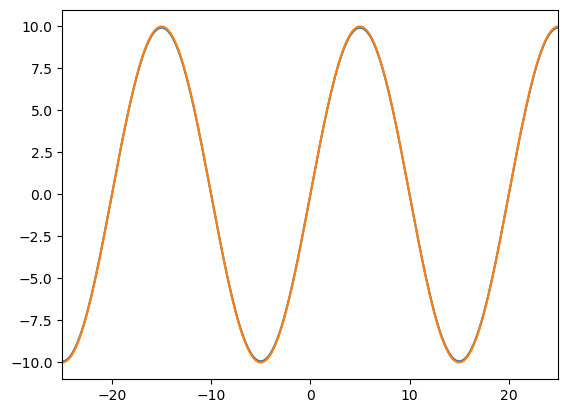

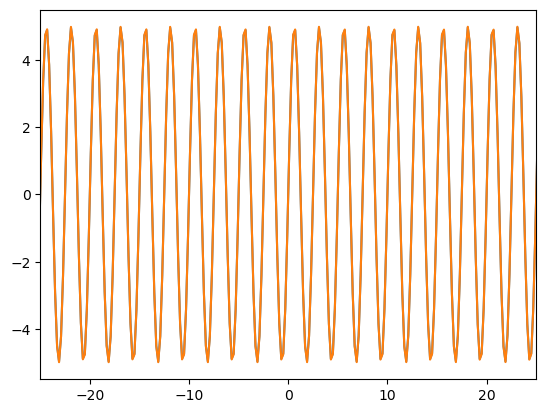

In [13]:
S_dir = sff.idct(S_estf)

plt.figure()
plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())
plt.plot(x_abs, S[0])
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())
plt.plot(x_abs, S[1])
plt.xlim([-25, 25])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




**Answer**:

The cost function is formulated as follows:

$$
\min_{A \in \mathbb{R}^{m \times n}, S \in \mathbb{R}^{m \times n}} \frac{1}{2} \|X - AS\|_F^2 + \lambda \|S\|_1 + \iota_{\{i \in [1,n]; \|\mathbf{a}_{i,j}\|_2^2 \leq 1 \}}(A)
$$

- **Data Fidelity Term**: $ \frac{1}{2} \|X - AS\|_F^2$ represents the data fidelity term, quantifying the disparity between the observed mixed signals $ X$ and the signals $ AS$ generated by the current estimates of $ A$ and $ S$. The objective is to minimize this discrepancy, and the term is smooth and convex as it constitutes a quadratic function of $ A$ and $ S$.

- **Sparsity Term**: $ \lambda \|S\|_1$ serves as the regularization term, imposing a penalty based on a measure of the sparsity of $ S$.

- **Oblique Constraint**: $ \iota_{\{i \in [1,n]; \|a_{i,j}\|_2^2 \leq 1 \}}(A)$ is the oblique constraint ensuring that the columns of the mixing matrix $ A$ have a unit norm, meaning each column vector has a length or magnitude of 1. This constraint is essential for addressing the inherent scale ambiguity in blind source separation problems. Without constraints, the problem would have an infinite number of solutions due to the ability to counterbalance any scaling of the sources with an inverse scaling of the mixing matrix. By enforcing unit norm columns in $ A$, this ambiguity is resolved, rendering the problem better-posed and more tractable. However, it's worth noting that this is a non-convex constraint, adding complexity to the optimization process.

Recall what the gradient of the data fidelity term over A is.

**Answer**:

The gradient of the data-fidelity term with respect to \( A \) can be expressed as:

$$\nabla_A \left( \frac{1}{2} \|X - AS\|_F^2 \right) = -S^T(X - AS)$$

Compte the proximal operator of the oblique constraint. Implement it.

**Answer**:

$$
\text{prox}_{\iota_{\{ \forall i \in [1,n]; \|\mathbf{a}_{:,j}\|_{l_2}^2 \leq 1 \}}}(A) = \begin{cases} 
\frac{\mathbf{a}_{:,j}}{\|\mathbf{a}_{:,j}\|_{l_2}} & \text{if } \|\mathbf{a}_{:,j}\|_{l_2} > 1 \\
\mathbf{a}_{:,j} & \text{otherwise}
\end{cases}
$$

In [14]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        A[:, j] /= max(1, np.linalg.norm(A[:, j]))
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [15]:
def PALM(X, n=2, lamb=0, nbIt=100):
    S_est = np.zeros((n, X.shape[1]))
    A_est = np.eye(X.shape[0], n)
    for i in range(nbIt):
        S_est = prox_l1(
            S_est
            + (0.9 / (np.linalg.norm(A_est.T @ A_est) + np.nextafter(0, 1)))
            * (np.dot(A_est.T, (X - np.dot(A_est, S_est)))),
            lamb,
        )
        A_est = prox_oblique(
            A_est
            + (0.9 / (np.linalg.norm(S_est @ S_est.T) + np.nextafter(0, 1)))
            * np.dot((X - np.dot(A_est, S_est)), S_est.T)
        )

    return A_est, S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

**Answer**:

Upon visual inspection of the true and estimated sources, it is evident that the separation quality is exceptionally high. The estimated sources closely resemble the originals, with negligible scale factors, phase shifts, or permutations observed. While a slight phase shift is discernible, it is notably smaller than that observed in the non-blind source separation scenario.

Furthermore, examination of the true and estimated mixing matrices $A$ reveals striking similarity, indicating the effectiveness of the PALM algorithm in "unmixing" the sources from the observed data. This congruence underscores the algorithm's success in accurately recovering the mixing process, further corroborating the fidelity of the source separation outcome.

In [16]:
A_est, S_est = PALM(Xf, n=2, lamb=1000, nbIt=1000)

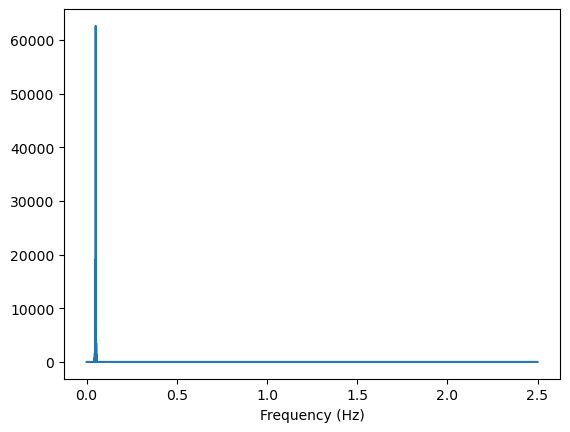

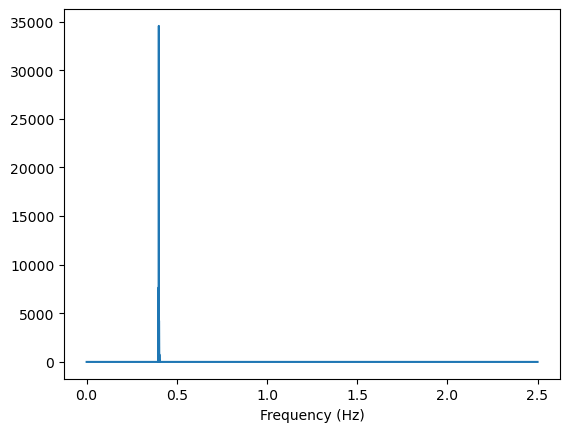

In [17]:
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(S_est[0, :]) )
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(S_est[1, :]) )
plt.xlabel("Frequency (Hz)")
plt.show()

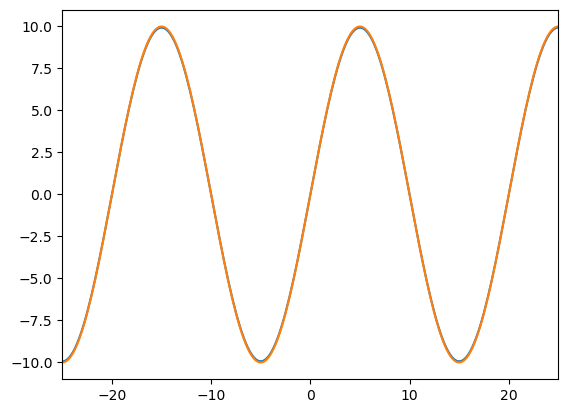

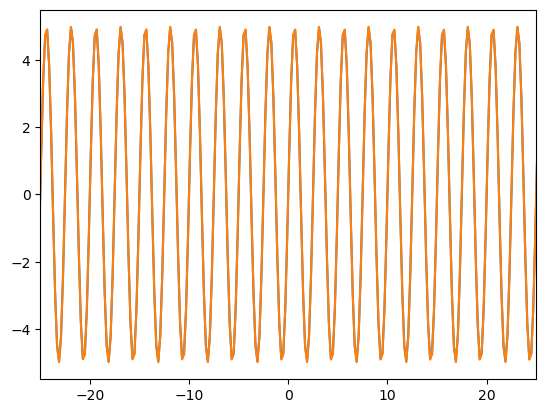

In [18]:
S_dir = sff.idct(S_est)

plt.figure()
plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())
plt.plot(x_abs, S[0])
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())
plt.plot(x_abs, S[1])
plt.xlim([-25, 25])
plt.show()

In [19]:
print("Matrix A:\n", A)
print("Matrix A_est:\n", A_est)

Matrix A:
 [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Matrix A_est:
 [[0.55457274 0.24507083]
 [0.83213525 0.96950518]]
